In [39]:
%matplotlib inline

%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, os.path.abspath('../src'))
sys.path.insert(1, os.path.abspath('.'))


import matplotlib.pyplot as plt
from IPython.display import display
from models import model_input

import numpy as np
from PIL import Image
import tensorflow as tf






def show_img(img, cmap=None, interpolation=None):
    fig = plt.figure()
    plt.imshow(img, cmap=cmap)
    display(fig)
    plt.close()
    
def print_stats(img, show=True, cmap=None, interpolation=None):
    print("Shape:\t", img.shape)
    print("Type: \t", img.dtype)
    if show:
        show_img(img, cmap, interpolation)
        
def print_all(img):
    print_stats(img)
    print("Max: ", img.max())
    print("Min: ", img.min())

        
tfrecords_filename = '../data/processed/kitti/test.tfrecords'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


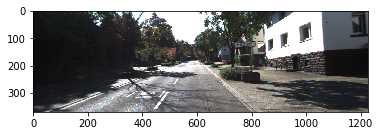

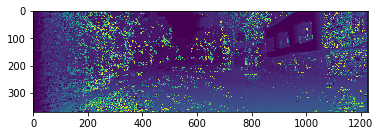

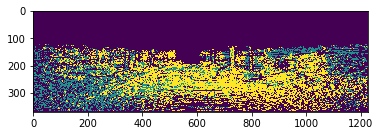

In [40]:
record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)


reconstructed_images = []
for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    left_raw = (example.features.feature['left_raw']
                                .bytes_list
                                .value[0])
    
    disp_raw = (example.features.feature['disp_raw']
                                .bytes_list
                                .value[0])
    
    conf_raw = (example.features.feature['conf_raw']
                                .bytes_list
                                .value[0])
    
    left_reconstructed = np.fromstring(left_raw, dtype=np.uint8).reshape((height, width, -1))
    disp_reconstructed = np.fromstring(disp_raw, dtype=np.uint8).reshape((height, width))
    conf_reconstructed = np.fromstring(conf_raw, dtype=np.float32).reshape((height, width))

    reconstructed_images.append((left_reconstructed, disp_reconstructed, conf_reconstructed))
    
plt.imshow(reconstructed_images[0][0])
plt.figure()
plt.imshow(reconstructed_images[0][1])
plt.figure()
plt.imshow(reconstructed_images[0][2])

Filling queue with 2 CIFAR images before starting to train. This will take a few minutes.
Shape:	 (256, 512, 3)
Type: 	 uint8


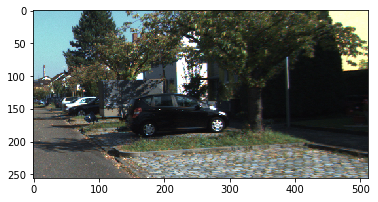

Shape:	 (256, 512)
Type: 	 float32


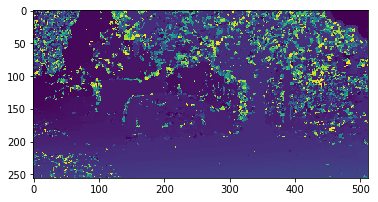

Shape:	 (256, 512)
Type: 	 float32


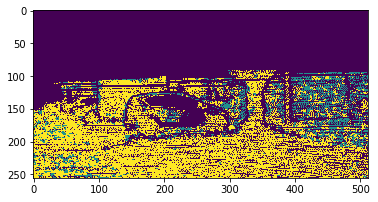

------------------------------------


In [41]:
filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs=1)


left, disp, conf = model_input.distorted_inputs('kitti', batch_size=2)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('../models/train',
                                      sess.graph)
    test_writer = tf.summary.FileWriter('../models/test')
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(1):
    
        l,d,g = sess.run([left,disp,conf])
        print_stats(np.squeeze(l[0,:,:,:]).astype(np.uint8))
        print_stats(np.squeeze(d[0,:,:,:]))
        print_stats(np.squeeze(g[0,:,:,:]))
        
        print("------------------------------------")
    
    coord.request_stop()
    coord.join(threads)

Filling queue with 2 CIFAR images before starting to train. This will take a few minutes.
Net shape:  (2, 128, 256, 64)  Scale shape  (2, 256, 512, 64)
Net shape:  (2, 64, 128, 128)  Scale shape  (2, 128, 256, 128)
Net shape:  (2, 32, 64, 256)  Scale shape  (2, 64, 128, 256)
Net shape:  (2, 16, 32, 512)  Scale shape  (2, 32, 64, 512)
Net shape:  (2, 32, 64, 1024)
Net shape:  (2, 64, 128, 512)
Net shape:  (2, 128, 256, 256)
Net shape:  (2, 256, 512, 1)
INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.
current batch
Shape:	 (256, 512, 3)
Type: 	 float32


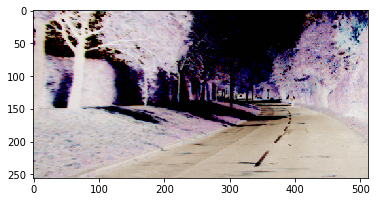

Shape:	 (256, 512)
Type: 	 float32


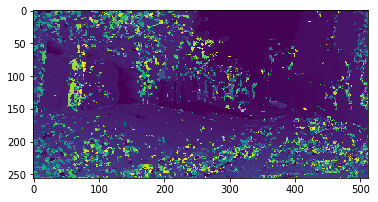

Shape:	 (256, 512)
Type: 	 float32


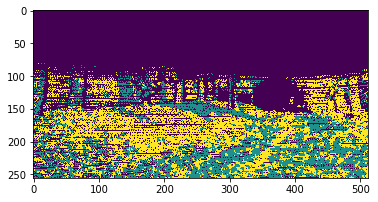

Shape:	 (256, 512)
Type: 	 float32


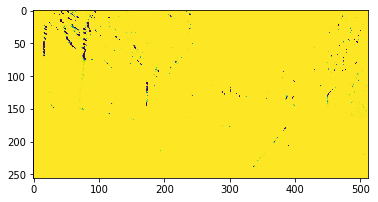

Max:  1.0
Min:  2.33989e-30
Calculated loss:  0.0
current batch
Shape:	 (256, 512, 3)
Type: 	 float32


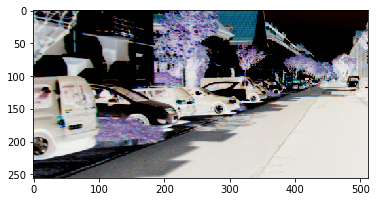

Shape:	 (256, 512)
Type: 	 float32


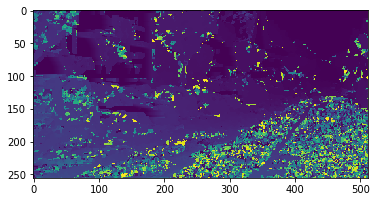

Shape:	 (256, 512)
Type: 	 float32


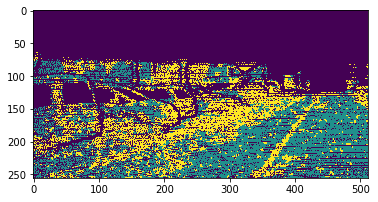

Shape:	 (256, 512)
Type: 	 float32


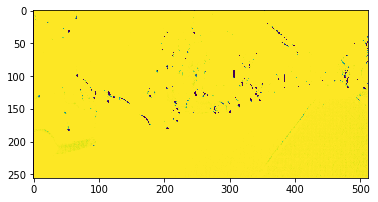

Max:  1.0
Min:  2.00031e-27
Calculated loss:  0.0
current batch
Shape:	 (256, 512, 3)
Type: 	 float32


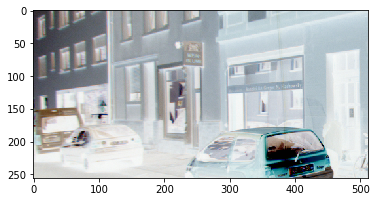

Shape:	 (256, 512)
Type: 	 float32


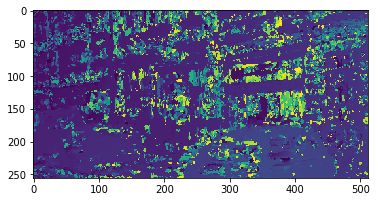

Shape:	 (256, 512)
Type: 	 float32


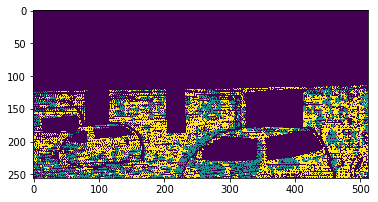

Shape:	 (256, 512)
Type: 	 float32


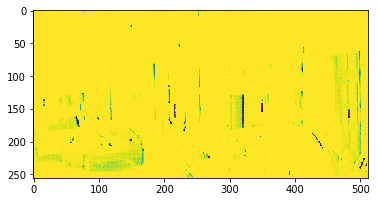

Max:  1.0
Min:  1.73907e-24
Calculated loss:  0.0


In [55]:
from models import model
tf.reset_default_graph()


left_op, disp_op, conf_op = model_input.distorted_inputs('kitti', batch_size=2)
logits_op, disparity_op = model.inference(left_op, disp_op)
loss_op = model.loss(logits_op, conf_op)

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('../models/train',
                                      sess.graph)
    test_writer = tf.summary.FileWriter('../models/test')
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    for i in range(3):
        
        left, disp, conf, disparity, loss = sess.run([left_op, disp_op, conf_op, lo, loss_op])
    
        print('current batch')
        
        print_stats(left[0,:,:,:])
        print_stats(np.squeeze(disp[0,:,:,:]))
        print_stats(np.squeeze(conf[0,:,:,:]))
        print_all(np.squeeze(disparity[0,:,:,:]))
        print("Calculated loss: ", loss)

    coord.request_stop()
    coord.join(threads)